# Neural tagger coarse-grained experiments analysis

In [1]:
from collections import defaultdict
import os
import pprint

from pymongo import MongoClient
from scipy.stats import f_oneway, ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

%matplotlib inline

In [2]:
client = MongoClient(os.environ['SACRED_MONGO_URL'])
db = client[os.environ['SACRED_DB_NAME']]

In [3]:
run_criteria = {
    'experiment.name': 'id-pos-tagging-neural-coarse',
    'meta.command': 'evaluate',
    'status': 'COMPLETED',
}

In [4]:
db.runs.count(run_criteria)

300

In [5]:
data = defaultdict(list)
for run in db.runs.find(run_criteria):
    data['run_id'].append(run['_id'])
    for conf in 'use_prefix use_suffix use_crf use_lstm window use_chars filter_width lr dropout'.split():
        data[conf].append(run['config'][conf])
    metric = db.metrics.find_one({'run_id': run['_id'], 'name': 'f1'})
    if metric is not None:
        if len(metric['values']) != 1:
            print(f"run {run['_id']} metric f1 has length != 1, taking the last one")
        data['f1'].append(metric['values'][-1])

In [6]:
df = pd.DataFrame(data)

In [7]:
len(df)

300

In [8]:
df.head()

,dropout,f1,filter_width,lr,run_id,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window
0,0.120527,0.952627,1,0.001088,2136,False,False,True,True,False,0
1,0.982863,0.025105,3,0.000001,2124,False,False,True,True,False,0
2,0.844358,0.469538,5,0.002508,2150,False,False,False,False,True,5
3,0.097453,0.926472,2,0.065522,2158,False,True,True,False,True,0
4,0.264586,0.910738,3,0.141809,2166,False,False,False,False,False,2


## Analyzing binary variables

### use_prefix

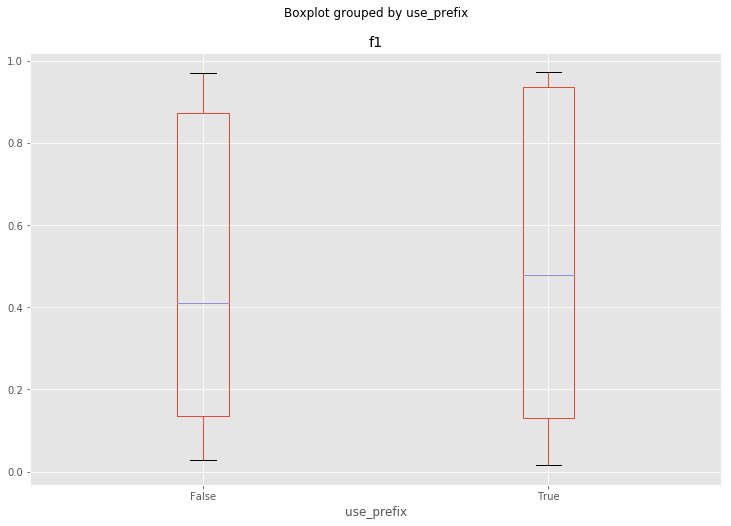

In [9]:
df.boxplot(column='f1', by='use_prefix', figsize=(12, 8))

In [10]:
ttest_ind(df[df.use_prefix]['f1'], df[~df.use_prefix]['f1'])

Ttest_indResult(statistic=0.8067253224908224, pvalue=0.42046811391470995)

There does not seem any difference between enabling prefix or not. Randomizing `use_prefix` for the fine-grained experiments seems necessary.

### use_suffix

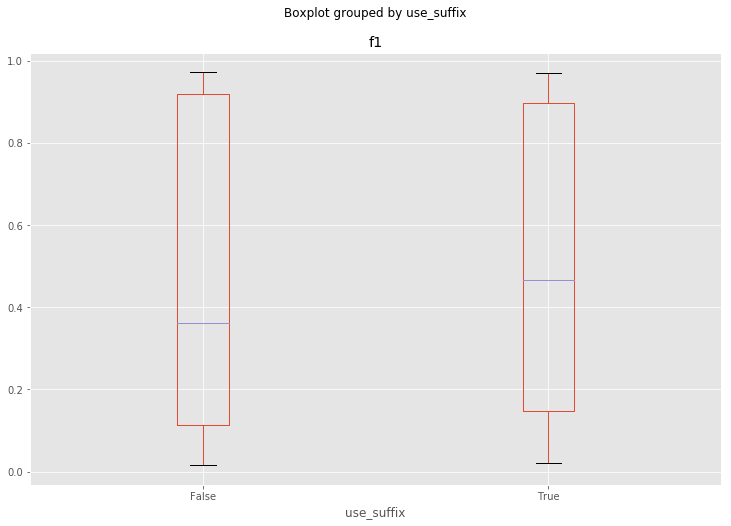

In [11]:
df.boxplot(column='f1', by='use_suffix', figsize=(12, 8))

In [12]:
ttest_ind(df[df.use_suffix]['f1'], df[~df.use_suffix]['f1'])

Ttest_indResult(statistic=0.451739454165157, pvalue=0.651785296012714)

Again, the same result with `use_prefix`. We need to randomize this for the fine-grained experiments.

### use_crf

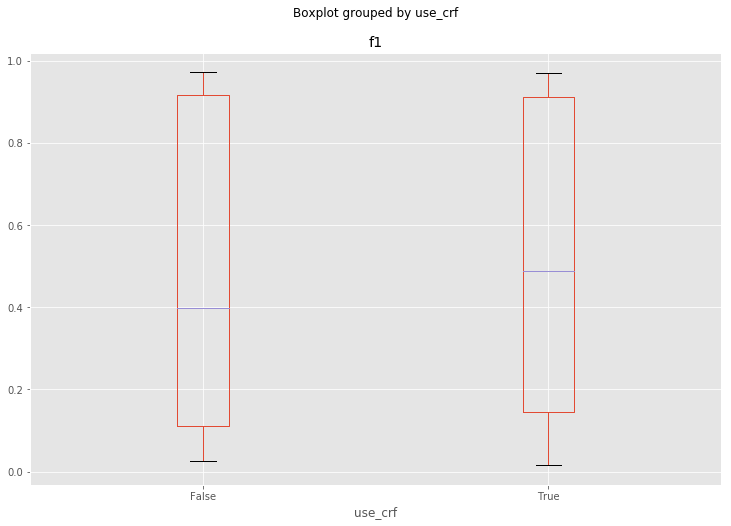

In [13]:
df.boxplot(column='f1', by='use_crf', figsize=(12, 8))

In [14]:
ttest_ind(df[df.use_crf]['f1'], df[~df.use_crf]['f1'])

Ttest_indResult(statistic=0.3785247728383696, pvalue=0.705310315404166)

No conclusion. Randomize this.

### use_lstm

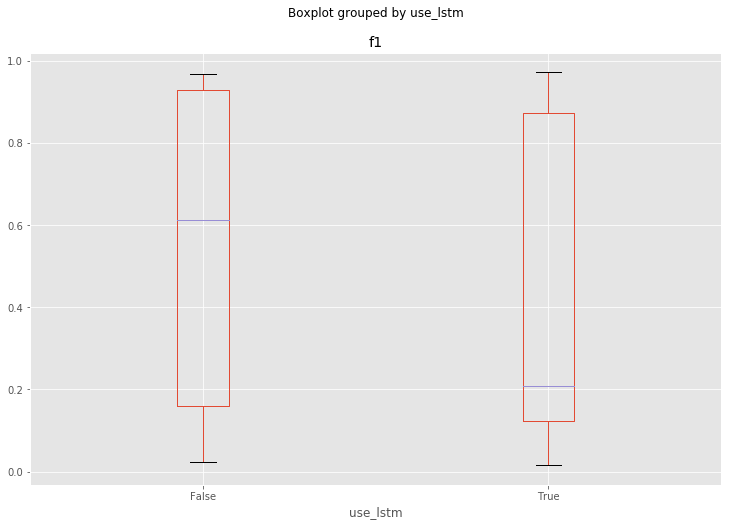

In [15]:
df.boxplot(column='f1', by='use_lstm', figsize=(12, 8))

In [16]:
ttest_ind(df[df.use_lstm]['f1'], df[~df.use_lstm]['f1'])

Ttest_indResult(statistic=-2.630178659399351, pvalue=0.008977375653538898)

In [17]:
df.groupby('use_lstm')['f1'].mean()

use_lstm
False    0.551310
True     0.439747
Name: f1, dtype: float64

Wow. This result suggests that `use_lstm=False` is significantly better than `True`. But we note that we're setting max epochs to 5, so this might be because LSTM needs more epochs to converge.

### use_chars

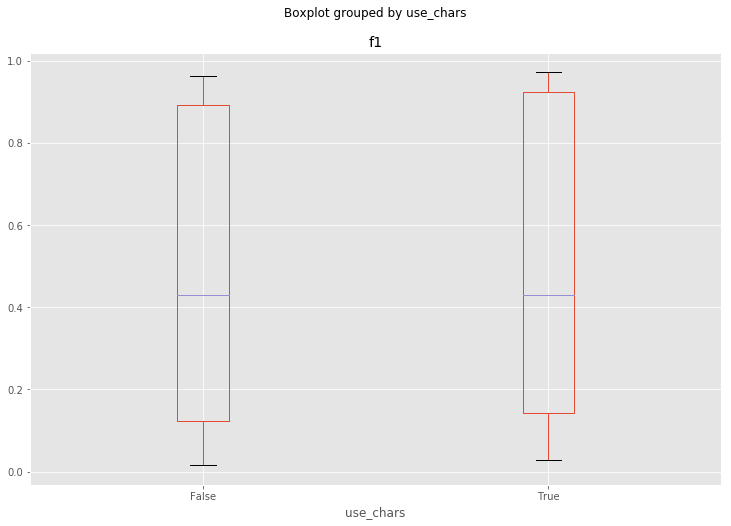

In [18]:
df.boxplot(column='f1', by='use_chars', figsize=(12, 8))

In [19]:
ttest_ind(df[df.use_chars]['f1'], df[~df.use_chars]['f1'])

Ttest_indResult(statistic=0.5979286272153963, pvalue=0.5503416831679753)

Inconclusive. Need to randomize `use_chars`.

## Analyzing multinomial variables

### window

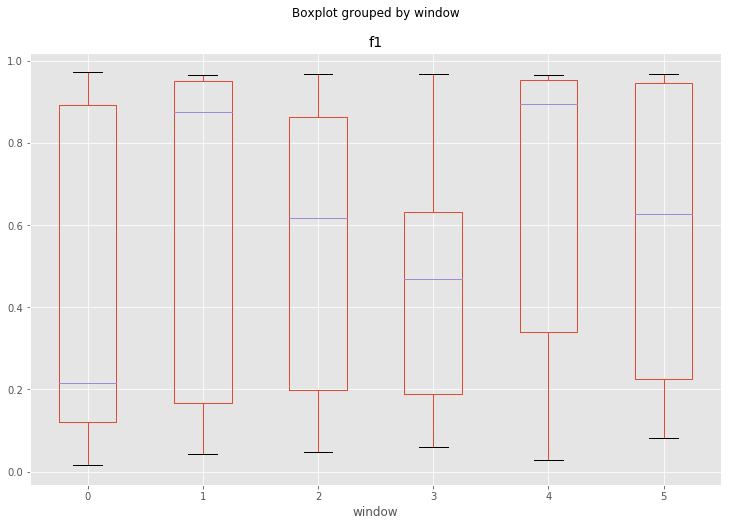

In [20]:
df.boxplot(column='f1', by='window', figsize=(12, 8))

In [21]:
samples = []
for window in df.window.unique():
    samples.append(df[df.window == window]['f1'])
f_oneway(*samples)

F_onewayResult(statistic=2.3930613126173115, pvalue=0.037814660687655516)

The p-value is low, so it seems that some window values are better than the others, even though its range is not obvious from the boxplot. We should randomize this again.

### filter_width

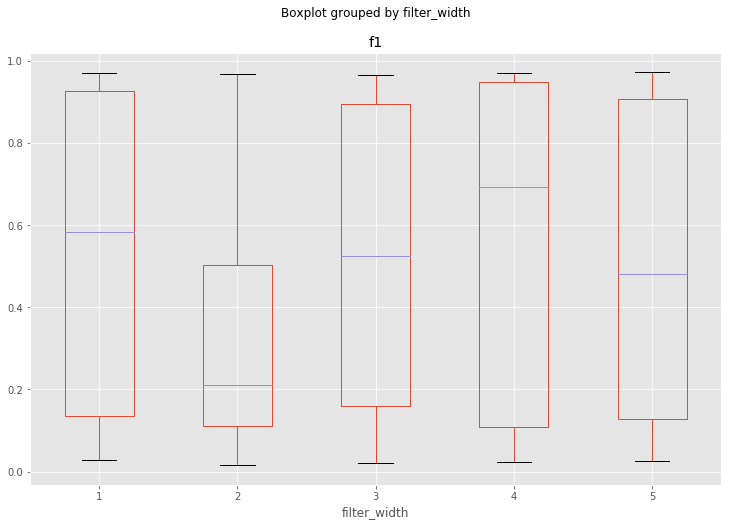

In [22]:
df.boxplot(column='f1', by='filter_width', figsize=(12, 8))

In [23]:
samples = []
for width in df.filter_width.unique():
    samples.append(df[df.filter_width == width]['f1'])
f_oneway(*samples)

F_onewayResult(statistic=2.793990146132192, pvalue=0.02649141918774314)

This case is the same as before. Need to randomize further.

## Analyzing continuous variables

### lr

In [24]:
df['log10_lr'] = np.log10(df.lr)

In [25]:
df.head()

,dropout,f1,filter_width,lr,run_id,use_chars,use_crf,use_lstm,use_prefix,use_suffix,window,log10_lr
0,0.120527,0.952627,1,0.001088,2136,False,False,True,True,False,0,-2.963395
1,0.982863,0.025105,3,0.000001,2124,False,False,True,True,False,0,-5.833397
2,0.844358,0.469538,5,0.002508,2150,False,False,False,False,True,5,-2.600750
3,0.097453,0.926472,2,0.065522,2158,False,True,True,False,True,0,-1.183613
4,0.264586,0.910738,3,0.141809,2166,False,False,False,False,False,2,-0.848296


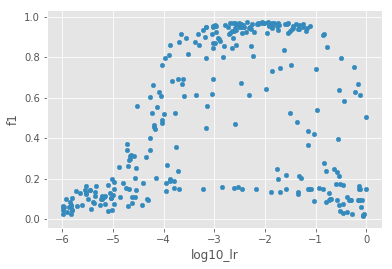

In [26]:
df.plot.scatter(x='log10_lr', y='f1')

The best range for `log10_lr` seems to be [-4, -1].

### dropout

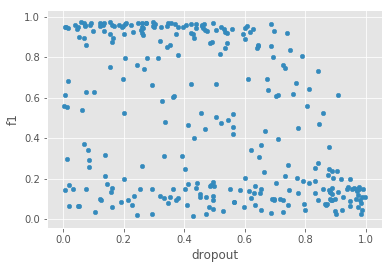

In [27]:
df.plot.scatter(x='dropout', y='f1')

The best range for `dropout` seems to be [0, 0.7).